In [1]:
import pandas as pd
import numpy as np
import sys
import time
import os
import sqlite3

sys.path.insert(0, '../src/data')

from make_dataset import *

%load_ext autoreload
%autoreload 2

In [25]:
def m(article, timeseries=False):
    revert = 0
    revert_pairs = []

    #the list of mutual reverting pairs
    mutual_revert_pairs = []
    #the list of unique users among reverting pairs
    mutual_revert_users = []

    #a dictionary of user as key, and his number of edits as the value
    user_edits = {}

    #a dictionary with the line number (actual version number) as key, and the line label as value(i.e. line label is either the same as version number if not revert version, or equal to an older version number if it's a revert version)
    lineLabels = []
    #a dictionary with the line number (actual version number) as key, and the author of that line as value
    lineAuthors = []
    
    # if scores
    scores_lst = []
    counter = 0

    ### Helper Function ###
    def getLine(label, lineLabels):
        for line, ll in reversed(list(enumerate(lineLabels))):
            if lineLabels[line] == label:
                return line
    
    ### Read File ###
    for ln in article:
        parts = ln
        if len(parts) < 4:
            continue

        if parts[3] not in user_edits:
            user_edits[parts[3]] = 1
        else:
            user_edits[parts[3]] = user_edits[parts[3]] + 1
        if parts[1] == '1':
            revert += 1
            #the found line is the version i-1 equal to this version j, and the revert is assumed to be between the author of i, and j
            line = getLine(int(parts[2]), lineLabels)
            #ignore cases when i-1, and i are equal (consecutive versions)
            if line >= len(lineLabels)-1:
                continue
            revertedU = lineAuthors[line + 1]
            revertingU = parts[3]
            if revertedU == revertingU:
                continue
            pair = revertedU + "~!~" + revertingU
            if pair not in revert_pairs:
                revert_pairs.append(pair)
        lineLabels.append(int(parts[2]))
        lineAuthors.append(parts[3])
        ### if we want the timeseries scores PUT INTO A FUNCTION ###
        if timeseries:
            if counter % 10 == 0:
                for pair in revert_pairs:
                    parts = pair.split("~!~")
                    if parts[1] + "~!~" + parts[0] in revert_pairs:
                        sorted_pair = ""
                        if parts[0] < parts[1]:
                            sorted_pair = parts[0] + "~!~" + parts[1]
                        else:
                            sorted_pair = parts[1] + "~!~" + parts[0]
                            mutual_revert_pairs.append(sorted_pair)
                        if parts[1] not in mutual_revert_users:
                            mutual_revert_users.append(parts[1])
                        if parts[0] not in mutual_revert_users:
                            mutual_revert_users.append(parts[0])

                score = 0
                pairs = []
                for pair in list(set(mutual_revert_pairs)):
                    parts = pair.split("~!~")
                    u1 = parts[0]
                    u2 = parts[1]
                    if user_edits[u1]<user_edits[u2]:
                        edit_min = user_edits[u1]
                    else:
                        edit_min = user_edits[u2]
                    pairs.append(pair + ":" + str(edit_min))
                    score += edit_min
                score *= len(mutual_revert_users)  
                scores_lst.append((counter, score))
                mutual_revert_pairs = []
                mutual_revert_users = []
        counter += 1

    ### Get Mutual ###
    for pair in revert_pairs:
        parts = pair.split("~!~")
        if parts[1] + "~!~" + parts[0] in revert_pairs:
            sorted_pair = ""
            if parts[0] < parts[1]:
                sorted_pair = parts[0] + "~!~" + parts[1]
            else:
                sorted_pair = parts[1] + "~!~" + parts[0]
                mutual_revert_pairs.append(sorted_pair)
            if parts[1] not in mutual_revert_users:
                mutual_revert_users.append(parts[1])
            if parts[0] not in mutual_revert_users:
                mutual_revert_users.append(parts[0])
        
        
    #calculating the score
    score = 0
    pairs = []
    for pair in list(set(mutual_revert_pairs)):
        parts = pair.split("~!~")
        u1 = parts[0]
        u2 = parts[1]
        if user_edits[u1]<user_edits[u2]:
            edit_min = user_edits[u1]
        else:
            edit_min = user_edits[u2]
        pairs.append(pair + ":" + str(edit_min))
        score += edit_min

    score *= len(mutual_revert_users)    
    
    ### if timeseries ###
    if timeseries:
        return pairs, scores_lst
    
    return score

### Create Articles List

In [15]:
### CHANGE TO ONE ARTICLE A TIME

def lightdump_m_all_articles(infp, outfp, chunksize=30000000):
    with open(infp) as fh:
        articles = []
        current_article = []
        first = True
        num_lines = 0
        for line in fh:
            if num_lines > chunksize:
                with open(outfp, 'a') as fh:
                    for name, values in articles:
                        pairs, score = m(values)
                        fh.write(name.strip() + '**,**' + str(score) + '\n')
                articles = []
                num_lines = 0
            if line[0] != '^':
                if first:
                    first = False
                else:
                    articles.append((article_name, current_article[::-1]))
                article_name = line.strip()
                current_article = []
            else:
                current_article.append(line.strip().split(' '))
            num_lines += 1
        with open(outfp, 'a') as fh:
                    for name, values in articles:
                        pairs, score = m(values)
                        fh.write(name.strip() + '**,**' + str(score) + '\n')

In [13]:
en_fp = '../data/raw/lightdump/en_wiki.txt'
simple_fp = '../data/raw/lightdump/simple_wiki.txt'

#### Simple Wiki

In [24]:
start_time = time.time()
simple_articles = lightdump_all_articles(simple_fp)
print(time.time() - start_time)

1.4308757781982422


In [25]:
# Write to file
with open('../data/ms/simple_ms.txt', 'w') as fh:
    for name, values in simple_articles:
        pairs, score = m(values)
        fh.write(name.strip() + '**,**' + str(score) + '\n')

#### En Wiki

In [8]:
# start_time = time.time()

# # extract ld
# en_articles = lightdump_all_articles(en_fp, start_article='Single-stage-to-orbit', chunksize=30000000)

# start_time = time.time()
# # Write to file
# with open('../data/ms/en_ms_22.txt', 'w') as fh:
#     for name, values in en_articles:
#         pairs, score = m(values)
#         fh.write(name.strip() + '**,**' + str(score) + '\n')
        
# print(time.time() - start_time)

451.25451374053955


In [16]:
# # concat
# filenames = os.listdir('../data/ms')
# with open('../data/ms/en_ms.txt', 'w') as outfile:
#     for fname in filenames:
#         with open('../data/ms/' + fname) as infile:
#             outfile.write(infile.read())

In [16]:
# start_time = time.time()
# lightdump_m_all_articles(en_fp, '../data/ms/en_ms_test.txt')
# print(time.time() - start_time)

TypeError: 'float' object is not callable

### EDA

#### Simple Wiki

In [41]:
# Open from file
with open('../data/ms/simple_ms.txt') as fh:
    simple_ms = []
    for line in fh:
        line = line.strip().split('**,**')
        if len(line) == 1:
            simple_ms.append(['', int(line[0])])
        else:
            try:
                simple_ms.append((line[0], int(line[1])))
            except:
                print(line)
                break

In [43]:
idx_n, values_n = zip(*simple_ms)
simple_ms_ser = pd.Series(values_n, idx_n)

In [49]:
print(np.percentile(simple_ms_ser, 5))
print(np.percentile(simple_ms_ser, 90))
print(np.percentile(simple_ms_ser, 95))
print(np.percentile(simple_ms_ser, 99))

0.0
0.0
0.0
4.0


#### En Wiki

In [2]:
# Open from file
with open('../data/ms/en_ms.txt') as fh:
    new_ms = []
    for line in fh:
        line = line.strip().split('**,**')
        if len(line) == 1:
            new_ms.append(['', int(line[0])])
        else:
            try:
                new_ms.append((line[0], int(line[1])))
            except:
                print(line)
                break

In [3]:
len(new_ms)

4644557

In [4]:
new_ms[0]

('Blackboard', 0)

In [5]:
idx_n, values_n = zip(*new_ms)
ms_ser = pd.Series(values_n, idx_n)

In [6]:
sorted_ms_ser = ms_ser.sort_values(ascending=False)

### Bill Gates Exploration

In [87]:
gates = lightdump_one_article('../data/raw/lightdump/en_wiki.txt', 'Bill_Gates')

In [88]:
len(gates)

10958

In [109]:
gates_scores = m(gates, timeseries=True)

In [110]:
idx_n, values_n = zip(*gates_scores[1])
gates_scores_ser = pd.Series(values_n, idx_n)

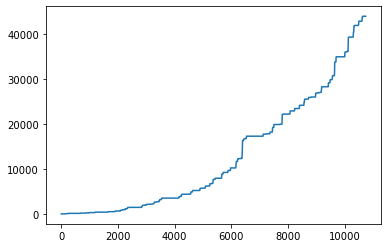

In [111]:
gates_scores_ser.plot()

In [128]:
gates[9630]

'^^^_2008-01-23T13:09:21Z 0 6335 Charlestrenet'

In [129]:
gates[9640]

'^^^_2008-01-25T17:41:41Z 0 6343 Superm401'

### Bot Exploration

In [50]:
con1.close()

In [31]:
con1 = sqlite3.connect('/teams/DSC180A_FA20_A00/b03onlinecommunities/personal-group01/en_wiki.db')

In [45]:
e = con1.execute("select * from articles limit 500")

In [49]:
test = pd.read_sql('select * from edits limit 500', con1)
test[test.revert == '1']

,article_id,timestamp,revert,edit_id,username
70,27,^^^_2010-02-02T07:34:57Z,1,1,Limenlemony
94,33,^^^_2010-02-02T07:16:28Z,1,1,Jorge_Stolfi
99,35,^^^_2010-02-02T07:16:52Z,1,1,Jorge_Stolfi
141,40,^^^_2006-03-16T22:34:52Z,1,14,AJR
144,40,^^^_2006-04-02T15:01:02Z,1,16,AJR
174,40,^^^_2007-03-02T00:54:47Z,1,45,AJR
191,40,^^^_2008-08-30T02:13:22Z,1,61,144.138.244.215
218,40,^^^_2010-02-02T06:58:47Z,1,87,Fastily
231,45,^^^_2010-02-02T06:44:02Z,1,1,Elionwyr
267,54,^^^_2010-02-02T06:47:59Z,1,2,Montelaba


In [2]:
con = sqlite3.connect('/teams/DSC180A_FA20_A00/b03onlinecommunities/personal-group01/simple_wiki.db')

In [3]:
articles = pd.read_sql('select * from articles', con=con)

In [4]:
edits = pd.read_sql('select * from edits', con=con)

In [18]:
edits.head(10)

,article_id,timestamp,revert,edit_id,username
0,0,^^^_2011-10-28T12:28:07Z,0,1,Rock_drum
1,0,^^^_2011-10-28T12:51:21Z,0,2,MystBot
2,1,^^^_2011-10-28T06:47:52Z,0,1,September_1988
3,1,^^^_2011-10-28T06:51:15Z,0,2,Luckas-bot
4,1,^^^_2011-10-28T08:29:46Z,0,3,DJDunsie
5,1,^^^_2011-10-28T08:30:30Z,0,4,DJDunsie
6,1,^^^_2011-10-28T08:31:56Z,0,5,DJDunsie
7,1,^^^_2011-10-28T08:32:21Z,0,6,DJDunsie
8,1,^^^_2011-10-28T08:32:39Z,0,7,DJDunsie
9,2,^^^_2011-10-28T02:42:23Z,0,1,PiRSquared17


In [6]:
bots = edits[edits.username.str.lower().str[-3:] == 'bot']

In [7]:
len(bots) / len(edits)

0.475635526028611

In [8]:
bots.revert.astype(int).mean()

0.016056307857730885

In [19]:
botcounts = bots.groupby('article_id')['username'].count().reset_index()
editcounts = edits.groupby('article_id')['username'].count().reset_index()

In [20]:
botcounts

,article_id,username
0,0,1
1,1,1
2,100,1
3,1000,3
4,10000,2
...,...,...
70068,9994,7
70069,9995,8
70070,9996,1
70071,9997,1


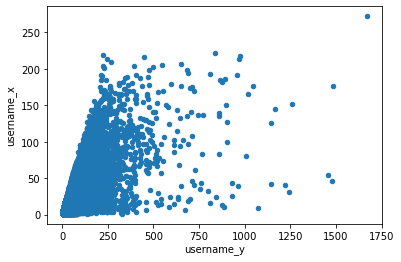

In [24]:
botcounts.merge(editcounts, on='article_id').plot.scatter(x='username_y', y='username_x')

In [14]:
articles.iloc[17437]

article_id        17437
article_name    Germany
num_edits           836
m                    35
Name: 17437, dtype: object

In [11]:
us = edits[edits.article_id == '17495']
us.head()

,article_id,timestamp,revert,edit_id,username
191255,17495,^^^_2003-10-21T02:08:57Z,0,1,RJ208153.user.veloxzone.com.br
191256,17495,^^^_2003-10-21T02:12:53Z,0,2,RJ208153.user.veloxzone.com.br
191257,17495,^^^_2003-10-21T02:13:21Z,0,3,RJ208153.user.veloxzone.com.br
191258,17495,^^^_2003-11-20T00:01:41Z,0,4,ip68-110-241-221.dc.dc.cox.net
191259,17495,^^^_2003-11-26T18:57:44Z,0,5,bgp535296bgs.ebrnsw01.nj.comcast.net


In [ ]:
us_bots = us[us.username.str.lower().str[-3:] == 'bot']
us_bots

In [28]:
us_reverts = us[us.revert == '1']
us_reverts.head()

,article_id,timestamp,revert,edit_id,username
191290,17495,^^^_2004-04-16T02:07:14Z,1,34,SimonMayer
191295,17495,^^^_2004-05-18T22:40:32Z,1,38,Angela
191318,17495,^^^_2004-11-06T03:04:25Z,1,60,62.165.128.200
191335,17495,^^^_2005-02-06T08:04:31Z,1,76,Netoholic
191367,17495,^^^_2005-05-28T19:25:53Z,1,105,Bluemask


In [30]:
(us_reverts.username.str.lower().str[-3:] == 'bot').mean()

0.030690537084398978

In [ ]:
us_bots.revert.astype(int).mean()

In [81]:
edits['revert'] = edits['revert'].astype(int)
user_counts = edits.groupby('username').agg({'timestamp': 'count', 'revert': 'mean'}).reset_index()

In [82]:
bot_counts = user_counts[user_counts.username.str.lower().str[-3:] == 'bot']
human_counts = user_counts[~(user_counts.username.str.lower().str[-3:] == 'bot')]

In [83]:
bot_counts

,username,timestamp,revert
26,.anacondabot,2,0.000000
76699,718_Bot,11,0.000000
121926,A4bot,3,0.000000
121955,AEBot,1,0.000000
121964,AHbot,25,0.000000
...,...,...,...
146648,Zxabot,219,0.000000
146654,Zyxwvut-Bot,2,0.000000
146662,ZéroBot,9892,0.002224
146884,Δbot,1,1.000000


In [84]:
human_counts

,username,timestamp,revert
0,"""Fingers""_Mc_Gee",4,0.000000
1,"""In_Avos'_we_trust""",1,0.000000
2,&action=edit,13,0.076923
3,&£$%;?@!!!,1,1.000000
4,(aeropagitica),2,0.000000
...,...,...,...
147070,치묘,5,0.000000
147071,쿠도군,2,0.000000
147072,트리플루,2,0.000000
147073,현철환,58,0.000000


In [75]:
bot_counts.timestamp.describe()

count      337.000000
mean      2825.922849
std       9769.486337
min          1.000000
25%          2.000000
50%         25.000000
75%       1078.000000
max      84973.000000
Name: timestamp, dtype: float64

In [78]:
human_counts.timestamp.describe()

count    146738.000000
mean          7.154950
std         180.379792
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       29646.000000
Name: timestamp, dtype: float64

In [86]:
bot_counts.revert.describe()

count    337.000000
mean       0.058761
std        0.198359
min        0.000000
25%        0.000000
50%        0.000000
75%        0.016181
max        1.000000
Name: revert, dtype: float64

In [88]:
human_counts.revert.describe()

count    146738.000000
mean          0.037930
std           0.159086
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: revert, dtype: float64

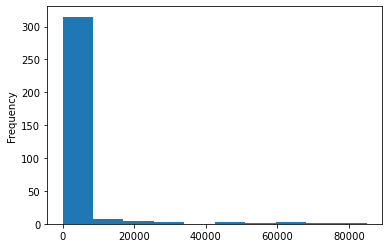

In [63]:
bot_counts.timestamp.plot.hist()

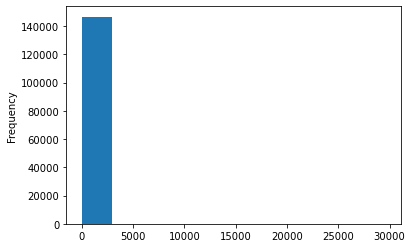

In [64]:
human_counts.timestamp.plot.hist()

In [89]:
(bot_counts.timestamp < 50).mean()

0.5341246290801187

In [72]:
(human_counts.timestamp < 50).mean()

0.9917540105494146

In [79]:
len(bot_counts) / (len(bot_counts) + len(human_counts))

0.00229134795172531